In [82]:
from copy import copy
import pandas as pd

from definitions import OIL_FILE, HOLIDAY_EVENTS_FILE, TRAIN_FILE

oil_df = pd.read_csv(OIL_FILE, parse_dates=['date'])
print(oil_df.head())

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20


## Dates
inspecting the date column

In [83]:
from EDA.analysis import get_missing_dates

print(oil_df['date'].describe(datetime_is_numeric=True))

print(f"has nans: {oil_df['date'].hasnans}")
missing_dates = get_missing_dates(oil_df['date'])
print(f'There are {len(missing_dates)} missing dates.')
print('Lets see which weekdays:')
print(missing_dates.weekday.unique())

count                   1218
mean     2015-05-02 12:00:00
min      2013-01-01 00:00:00
25%      2014-03-03 06:00:00
50%      2015-05-02 12:00:00
75%      2016-06-30 18:00:00
max      2017-08-31 00:00:00
Name: date, dtype: object
has nans: False
There are 486 missing dates.
Lets see which weekdays:
Int64Index([5, 6], dtype='int64')


The dates range from 2013-01-01 to 2017-08-31
There are no nans but the weekend days are missing as the market is probably closed.

In [84]:
## prices
print(oil_df['dcoilwtico'].describe())
print(oil_df['dcoilwtico'].hasnans)
print(oil_df['dcoilwtico'].isna().sum())

count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64
True
43


Prices range from 26 to 110 and there seem to be some days without a valid price, perhaps they are holidays.

In [85]:
dates_with_nan_price = oil_df[oil_df['dcoilwtico'].isna()].date
holiday_df = pd.read_csv(HOLIDAY_EVENTS_FILE, parse_dates=['date'])
holiday_dates = holiday_df['date'].unique()

# Some dates with NaN prices that are holidays.
print(dates_with_nan_price.isin(holiday_dates).value_counts())

# For the remaining dates it is unknown why the price is missing.
print(dates_with_nan_price[~dates_with_nan_price.isin(holiday_dates)])

False    26
True     17
Name: date, dtype: int64
14     2013-01-21
34     2013-02-18
63     2013-03-29
104    2013-05-27
132    2013-07-04
174    2013-09-02
237    2013-11-28
274    2014-01-20
294    2014-02-17
364    2014-05-26
434    2014-09-01
497    2014-11-27
534    2015-01-19
624    2015-05-25
699    2015-09-07
757    2015-11-26
794    2016-01-18
814    2016-02-15
889    2016-05-30
914    2016-07-04
959    2016-09-05
1017   2016-11-24
1054   2017-01-16
1079   2017-02-20
1149   2017-05-29
1175   2017-07-04
Name: date, dtype: datetime64[ns]


Lets plot the price data.

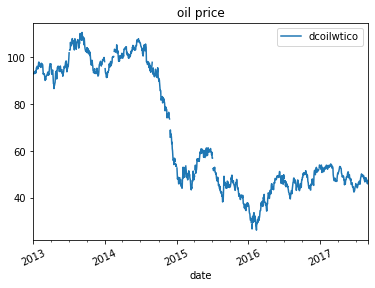

'Prices drop belos 70 at: 2014-11-28 00:00:00'

In [86]:
from matplotlib import pyplot as plt
oil_df_indexed = oil_df.set_index('date')
oil_df_indexed.plot(rot=25, title='oil price')
plt.show()
f'Prices drop belos 70 at: ' + str(oil_df_indexed[oil_df_indexed['dcoilwtico'] < 70].iloc[0].name)

There is a steep drop in oil prices at the end of 2014.

## Correlation

Finally lets see the relation between the oil price and daily sales.

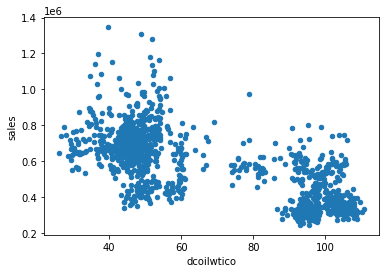

            dcoilwtico     sales
dcoilwtico    1.000000 -0.705002
sales        -0.705002  1.000000


In [87]:
train_df = pd.read_csv(TRAIN_FILE, parse_dates=['date'])

# Create a dataset with daily figures.
daily_figures = train_df.groupby('date').sum()[['sales']]

# Merge left as the daily_figures only contains training dates.
oil_and_sales_df = oil_df.merge(daily_figures, on='date', how='left')
oil_and_sales_df.plot.scatter('dcoilwtico', 'sales')
plt.show()
plt.close()
print(oil_and_sales_df.corr())


There is a negative relation between oil prices and sale volumes (-0.7 pearson).

However the scatter dot doesn't show a clear negative relation but rather two cluster. One cluster consists of low prices and high sales and the other contains higher prices and lower sales. The difference in oil prices is caused by the sharp drop at the end of 2014. The difference in sales is a lot smaller but higher sales seem to occur with lower oil prices. However this is true because the lower oil prices happen in later years, as do higher sales. Tims seems to be the common cause of both high sales and low oil prices.

to verify the above we will split the dataset in one before and after the price drop and see if the correlation holds for both. Also we'll plot the sales as a time series and see if it truly rises with tim.

Correlation before oil prices drop.
            dcoilwtico     sales
dcoilwtico    1.000000 -0.308611
sales        -0.308611  1.000000

Correlation after oil prices drop.
            dcoilwtico     sales
dcoilwtico    1.000000 -0.123917
sales        -0.123917  1.000000



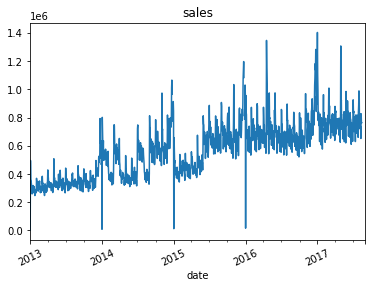

In [88]:
print('Correlation before oil prices drop.')
pre_oil_price_drop = oil_and_sales_df[oil_and_sales_df['date'] < '2014-11-28']
print(pre_oil_price_drop.corr())
print()
print('Correlation after oil prices drop.')
post_oil_price_drop = oil_and_sales_df[oil_and_sales_df['date'] > '2014-11-28']
print(post_oil_price_drop.corr())
print()
oil_and_sales_df = oil_and_sales_df.set_index('date')
oil_and_sales_df['sales'].plot(rot=25, title='sales')
plt.show()
plt.close()

Both correlations are now only -0.3 and -0.12, no longer significant. Also as expected the overall sales increases through time.

However sales do seem to drop right after the end of 2014, which makes sense as the country was likely hit by an economic crisis.

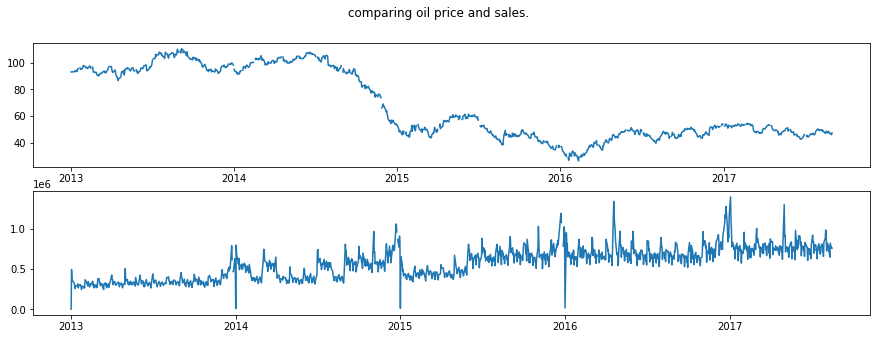

In [89]:
fig, (ax_upper, ax_lower) = plt.subplots(2)
fig.suptitle('comparing oil price and sales.')
fig.set_size_inches(15, 5)
ax_upper.plot(oil_and_sales_df.index, oil_and_sales_df['dcoilwtico'])
ax_lower.plot(oil_and_sales_df.index, oil_and_sales_df['sales'])
plt.show()
plt.close()

1


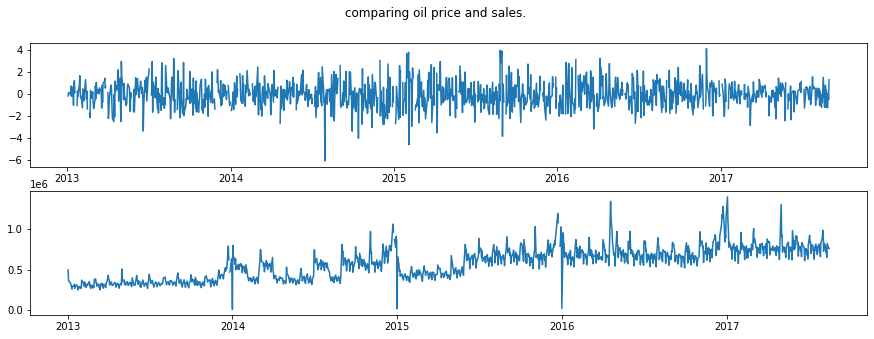

-0.025615210273872376
7


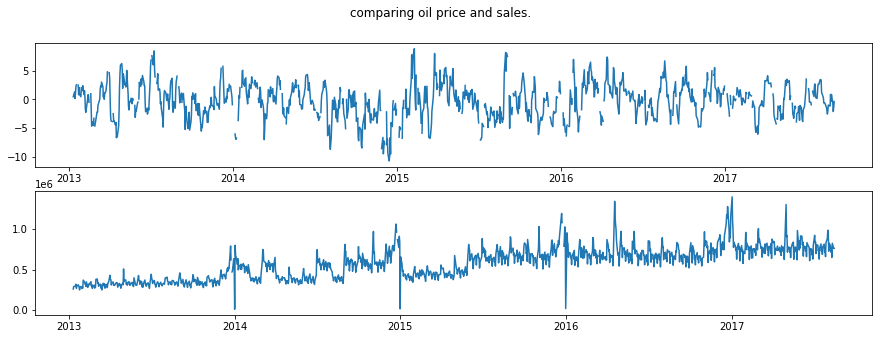

-0.042495128507843226
14


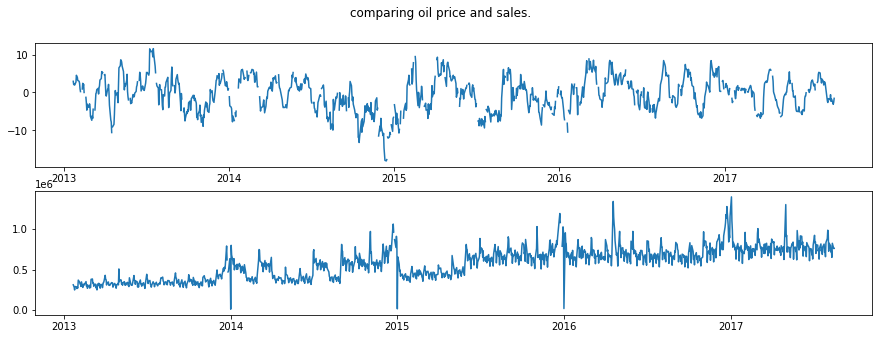

-0.06621137095317432
20


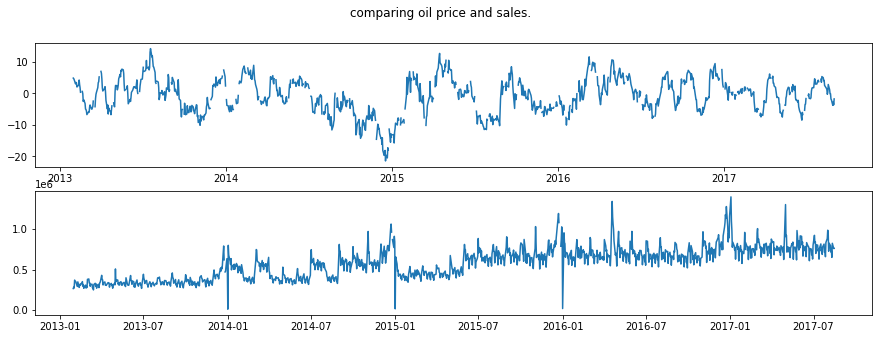

-0.0914690848078694
30


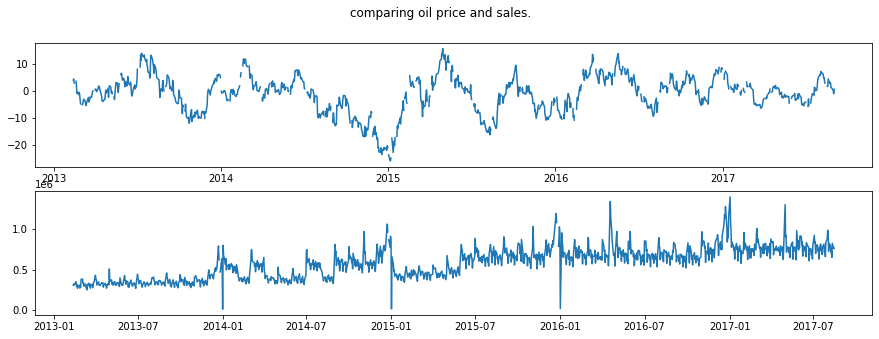

-0.0632827227961803
61


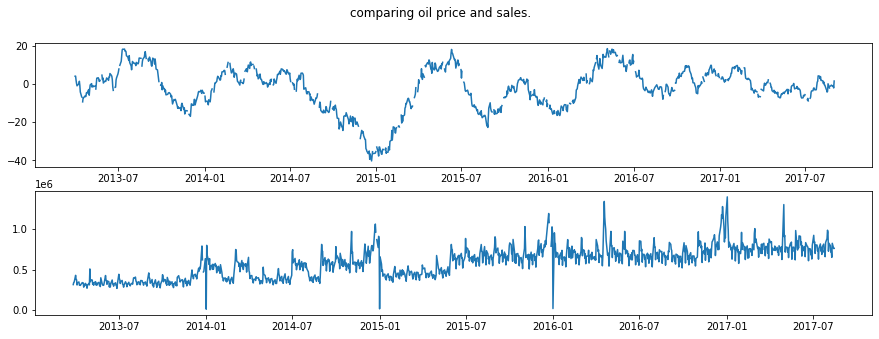

-0.06530887331691573
90


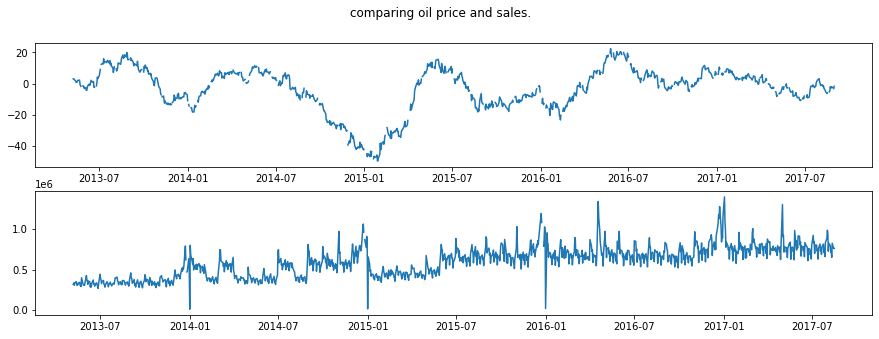

-0.019416421547524376
123


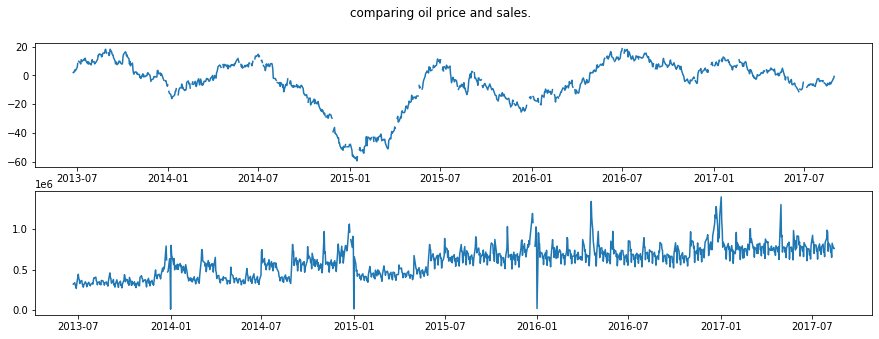

0.02171258818258975


In [93]:
d = 1
for d in [1, 7, 14, 20, 30, 61, 90, 123]:
    diff_test = copy(oil_and_sales_df)
    print(d)
    diff_test['diff'] = diff_test['dcoilwtico'].diff(d)
    diff_test = diff_test[d:]

    fig, (ax_upper, ax_lower) = plt.subplots(2)
    fig.suptitle('comparing oil price and sales.')
    fig.set_size_inches(15, 5)
    ax_upper.plot(diff_test.index, diff_test['diff'])
    ax_lower.plot(diff_test.index, diff_test['sales'])
    plt.show()
    plt.close()
    print(diff_test['sales'].corr(diff_test['diff']))

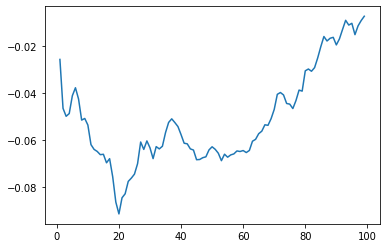

In [91]:
d = 1
all_diffs = []
all_corr = []
for d in range(100):
    diff_test = copy(oil_and_sales_df)
    diff_test['diff'] = diff_test['dcoilwtico'].diff(d)
    diff_test = diff_test[d:]

    # fig, (ax_upper, ax_lower) = plt.subplots(2)
    # fig.suptitle('comparing oil price and sales.')
    # fig.set_size_inches(15, 5)
    # ax_upper.plot(oil_and_sales_df.index, oil_and_sales_df['diff'])
    # ax_lower.plot(oil_and_sales_df.index, oil_and_sales_df['sales'])
    # plt.show()
    # plt.close()
    corr = diff_test['sales'].corr(diff_test['diff'])
    all_diffs.append(d)
    all_corr.append(corr)

diff_test_result = pd.Series(data=all_corr, index=all_diffs)
diff_test_result.plot()
plt.show()
plt.close()
